# Contextual Multi Armed Bandits with ✨Generative✨ Reward Functions

Inspiration from this idea - somewhat of a LLM distillation method:
https://arxiv.org/abs/2303.00001

### Reward Design with Language Models
##### Minae Kwon, Sang Michael Xie, Kalesha Bullard, Dorsa Sadigh
`Reward design in reinforcement learning (RL) is challenging since specifying human notions of desired behavior may be difficult via reward functions or require many expert demonstrations. Can we instead cheaply design rewards using a natural language interface? This paper explores how to simplify reward design by prompting a large language model (LLM) such as GPT-3 as a proxy reward function, where the user provides a textual prompt containing a few examples (few-shot) or a description (zero-shot) of the desired behavior. Our approach leverages this proxy reward function in an RL framework. Specifically, users specify a prompt once at the beginning of training. During training, the LLM evaluates an RL agent's behavior against the desired behavior described by the prompt and outputs a corresponding reward signal. The RL agent then uses this reward to update its behavior. We evaluate whether our approach can train agents aligned with user objectives in the Ultimatum Game, matrix games, and the DealOrNoDeal negotiation task. In all three tasks, we show that RL agents trained with our framework are well-aligned with the user's objectives and outperform RL agents trained with reward functions learned via supervised learning`

In this we will use PALM Text Bison. We will do the following

1. Generate "trajectory" training examples where we have a batch of n users, shown a randomly selected batch of n_actions movies
2. Take the raw textual data of those features and format a prompt asking text bison to rate the movie (float) on a 0-5 rating scale
3. These rewards are then used as we generte the reward and update the trajectory
4. Either generate the rest of these examples online (suggested for scale), or generate as-you-train
5. Create a deep network for an epsilon-greed multi-armed bandit agent to explore/exlpoit the rewards generated by text-bison


Future ideas

- When tempurature is set to high and/or token count is extended, it can be interesting to see it rationalize the ratings. 

- Mapreduce multiple prompts with...

- Mixture-of-experts approach

# Train Bandits with per-arm features

**Exploring linear and nonlinear** (e.g., those with neural network-based value functions) bandit methods for recommendations using TF-Agents

> Neural linear bandits provide a nice way to leverage the representation power of deep learning and the bandit approach for uncertainty measure and efficient exploration

## Load notebook config

* use the prefix defined in `00-env-setup`

In [1]:
PREFIX = 'mabv1'

In [2]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "wortz-project-352116"
PROJECT_NUM              = "679926387543"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"

VERTEX_SA                = "679926387543-compute@developer.gserviceaccount.com"

PREFIX                   = "mabv1"
VERSION                  = "v1"

BUCKET_NAME              = "mabv1-wortz-project-352116-bucket"
BUCKET_URI               = "gs://mabv1-wortz-project-352116-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://mabv1-wortz-project-352116-bucket/data"
VOCAB_SUBDIR             = "vocabs"
VOCAB_FILENAME           = "vocab_dict.pkl"

VPC_NETWORK_FULL         = "projects/679926387543/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_ID      = "wortz-project-352116.movielens_dataset_mabv1"
BIGQUERY_TABLE_ID        = "wortz-project-352116.movielens_dataset_mabv1.training_dataset"

REPO_D

## imports

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
import functools
from collections import defaultdict
from typing import Callable, Dict, List, Optional, TypeVar
from datetime import datetime
import time
from pprint import pprint
import pickle as pkl

# logging
import logging
logging.disable(logging.WARNING)

import matplotlib.pyplot as plt
import numpy as np

# google cloud
from google.cloud import aiplatform, storage

# tensorflow
import tensorflow as tf
# from tf_agents.agents import TFAgent

# from tf_agents.bandits.environments import stationary_stochastic_per_arm_py_environment as p_a_env
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
# from tf_agents.drivers import dynamic_step_driver
# from tf_agents.environments import tf_py_environment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

# from tf_agents.bandits.agents import lin_ucb_agent
# from tf_agents.bandits.agents import linear_thompson_sampling_agent as lin_ts_agent
from tf_agents.bandits.agents import neural_epsilon_greedy_agent
from tf_agents.bandits.agents import neural_linucb_agent
from tf_agents.bandits.networks import global_and_arm_feature_network
from tf_agents.bandits.policies import policy_utilities

from tf_agents.bandits.specs import utils as bandit_spec_utils
from tf_agents.trajectories import trajectory

# GPU
from numba import cuda 
import gc

import sys
sys.path.append("..")

# this repo
from src.per_arm_rl import data_utils
from src.per_arm_rl import data_config

# tf exceptions and vars
if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

/opt/conda/envs/tensorflow/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/envs/tensorflow/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/envs/tensorflow/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/envs/tensorflow/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/envs/tensorflow/lib/pytho

In [5]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)
    
# gpus

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [6]:
# device = cuda.get_current_device()
# device.reset()
# gc.collect()

In [7]:
# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
aiplatform.init(project=PROJECT_ID, location=LOCATION)

# Data prep

### Read TF Records

In [8]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.AUTO

In [9]:
SPLIT = "train" # "train" | "val"

train_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{DATA_GCS_PREFIX}/{SPLIT}'):
    if '.tfrecord' in blob.name:
        train_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
train_files

['gs://mabv1-wortz-project-352116-bucket/data/train/ml-ratings-100k-train.tfrecord']

In [10]:
train_dataset = tf.data.TFRecordDataset(train_files)
train_dataset = train_dataset.map(data_utils.parse_tfrecord)

for x in train_dataset.batch(1).take(1):
    pprint(x)

{'bucketized_user_age': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([35.], dtype=float32)>,
 'movie_genres': <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[7]])>,
 'movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'898'], dtype=object)>,
 'movie_title': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Postman, The (1997)'], dtype=object)>,
 'timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([885409515])>,
 'user_gender': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'False'], dtype=object)>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'681'], dtype=object)>,
 'user_occupation_label': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([14])>,
 'user_occupation_text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'marketing'], dtype=object)>,
 'user_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>,
 'user_zip_code': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'97208'], dtype=o

### get vocab

**TODO:** 
* streamline vocab calls

In [11]:
GENERATE_VOCABS = False
print(f"GENERATE_VOCABS: {GENERATE_VOCABS}")

VOCAB_SUBDIR   = "vocabs"
VOCAB_FILENAME = "vocab_dict.pkl"

GENERATE_VOCABS: False


In [12]:
if not GENERATE_VOCABS:

    EXISTING_VOCAB_FILE = f'gs://{BUCKET_NAME}/{VOCAB_SUBDIR}/{VOCAB_FILENAME}'
    print(f"Downloading vocab...")
    
    os.system(f'gsutil -q cp {EXISTING_VOCAB_FILE} .')
    print(f"Downloaded vocab from: {EXISTING_VOCAB_FILE}\n")

    filehandler = open(VOCAB_FILENAME, 'rb')
    vocab_dict = pkl.load(filehandler)
    filehandler.close()
    
    for key in vocab_dict.keys():
        pprint(key)

Downloaded vocab from: gs://mabv1-wortz-project-352116-bucket/vocabs/vocab_dict.pkl

'movie_id'
'user_id'
'user_occupation_text'
'movie_genres'
'bucketized_user_age'
'max_timestamp'
'min_timestamp'
'timestamp_buckets'


## helper functions

**TODO:**
* modularize in a train_utils or similar

In [13]:
def _add_outer_dimension(x):
    """Adds an extra outer dimension."""
    if isinstance(x, dict):
        for key, value in x.items():
            x[key] = tf.expand_dims(value, 1)
        return x
    return tf.expand_dims(x, 1)

# Multi-Armed Bandits with Per-Arm Features

In [14]:
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.replay_buffers import tf_uniform_replay_buffer

nest = tf.nest

## Preprocessing layers for global and arm features

The preproccesing layers will ultimately feed the two functions described below, both of which will ultimately feed the `Environment`

`global_context_sampling_fn`: 
* A function that outputs a random 1d array or list of ints or floats
* This output is the global context. Its shape and type must be consistent across calls.

`arm_context_sampling_fn`: 
* A function that outputs a random 1 array or list of ints or floats (same type as the output of `global_context_sampling_fn`). * This output is the per-arm context. Its shape must be consistent across calls.

In [15]:
NUM_OOV_BUCKETS        = 1
GLOBAL_EMBEDDING_SIZE  = 16
MV_EMBEDDING_SIZE      = 32 #32

### global context (user) features

#### user ID

In [16]:
user_id_input_layer = tf.keras.Input(
    name="user_id",
    shape=(1,),
    dtype=tf.string
)

user_id_lookup = tf.keras.layers.StringLookup(
    max_tokens=len(vocab_dict['user_id']) + NUM_OOV_BUCKETS,
    num_oov_indices=NUM_OOV_BUCKETS,
    mask_token=None,
    vocabulary=vocab_dict['user_id'],
)(user_id_input_layer)

user_id_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['user_id']) + NUM_OOV_BUCKETS,
    output_dim=GLOBAL_EMBEDDING_SIZE
)(user_id_lookup)

user_id_embedding = tf.reduce_sum(user_id_embedding, axis=-2)

# global_inputs.append(user_id_input_layer)
# global_features.append(user_id_embedding)

In [17]:
test_user_id_model = tf.keras.Model(inputs=user_id_input_layer, outputs=user_id_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["user_id"])
    print(test_user_id_model(x["user_id"]))

tf.Tensor([b'681'], shape=(1,), dtype=string)
tf.Tensor(
[[ 0.01806823 -0.04779295  0.0041648   0.00260639  0.03467104  0.04654689
   0.04471311  0.04795665  0.03117226 -0.04857733  0.03781874  0.00906665
   0.02386748 -0.04607007 -0.04949344 -0.02612308]], shape=(1, 16), dtype=float32)


#### user AGE

In [18]:
user_age_input_layer = tf.keras.Input(
    name="bucketized_user_age",
    shape=(1,),
    dtype=tf.float32
)

user_age_lookup = tf.keras.layers.IntegerLookup(
    vocabulary=vocab_dict['bucketized_user_age'],
    num_oov_indices=NUM_OOV_BUCKETS,
    oov_value=0,
)(user_age_input_layer)

user_age_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['bucketized_user_age']) + NUM_OOV_BUCKETS,
    output_dim=GLOBAL_EMBEDDING_SIZE
)(user_age_lookup)

user_age_embedding = tf.reduce_sum(user_age_embedding, axis=-2)

# global_inputs.append(user_age_input_layer)
# global_features.append(user_age_embedding)

In [19]:
test_user_age_model = tf.keras.Model(inputs=user_age_input_layer, outputs=user_age_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["bucketized_user_age"])
    print(test_user_age_model(x["bucketized_user_age"]))

tf.Tensor([35.], shape=(1,), dtype=float32)
tf.Tensor(
[[ 0.02718775  0.00225193 -0.01391349  0.02715372  0.00741552 -0.01082809
   0.04307974 -0.02445748  0.01875145  0.00548017  0.0299812   0.04886207
   0.03581295  0.01254937  0.00118531  0.0196553 ]], shape=(1, 16), dtype=float32)


#### user OCC

In [20]:
user_occ_input_layer = tf.keras.Input(
    name="user_occupation_text",
    shape=(1,),
    dtype=tf.string
)

user_occ_lookup = tf.keras.layers.StringLookup(
    max_tokens=len(vocab_dict['user_occupation_text']) + NUM_OOV_BUCKETS,
    num_oov_indices=NUM_OOV_BUCKETS,
    mask_token=None,
    vocabulary=vocab_dict['user_occupation_text'],
)(user_occ_input_layer)

user_occ_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['user_occupation_text']) + NUM_OOV_BUCKETS,
    output_dim=GLOBAL_EMBEDDING_SIZE
)(user_occ_lookup)

user_occ_embedding = tf.reduce_sum(user_occ_embedding, axis=-2)

# global_inputs.append(user_occ_input_layer)
# global_features.append(user_occ_embedding)

In [21]:
test_user_occ_model = tf.keras.Model(inputs=user_occ_input_layer, outputs=user_occ_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["user_occupation_text"])
    print(test_user_occ_model(x["user_occupation_text"]))

tf.Tensor([b'marketing'], shape=(1,), dtype=string)
tf.Tensor(
[[-0.01417934  0.02128417 -0.04060601 -0.01150981  0.00822403  0.03577134
  -0.02120326  0.04239904  0.04134711 -0.04658265  0.02343202 -0.03448397
   0.03723052  0.04310123 -0.02240143  0.01510868]], shape=(1, 16), dtype=float32)


#### user Timestamp

In [22]:
user_ts_input_layer = tf.keras.Input(
    name="timestamp",
    shape=(1,),
    dtype=tf.int64
)

user_ts_lookup = tf.keras.layers.Discretization(
    vocab_dict['timestamp_buckets'].tolist()
)(user_ts_input_layer)

user_ts_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['timestamp_buckets'].tolist()) + NUM_OOV_BUCKETS,
    output_dim=GLOBAL_EMBEDDING_SIZE
)(user_ts_lookup)

user_ts_embedding = tf.reduce_sum(user_ts_embedding, axis=-2)

# global_inputs.append(user_ts_input_layer)
# global_features.append(user_ts_embedding)

In [23]:
test_user_ts_model = tf.keras.Model(inputs=user_ts_input_layer, outputs=user_ts_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["timestamp"])
    print(test_user_ts_model(x["timestamp"]))

tf.Tensor([885409515], shape=(1,), dtype=int64)
tf.Tensor(
[[-0.03811013  0.02838352 -0.03494694  0.0208756   0.03828151 -0.04900249
  -0.02319418  0.02015351  0.04617448 -0.04039234 -0.00997448  0.0416292
   0.03852597  0.03787447 -0.04810251 -0.01708328]], shape=(1, 16), dtype=float32)


#### define global sampling function

In [24]:
def _get_global_context_features(x):
    """
    This function generates a single global observation vector.
    """
    user_id_value = x['user_id']
    user_age_value = x['bucketized_user_age']
    user_occ_value = x['user_occupation_text']
    user_ts_value = x['timestamp']

    _id = test_user_id_model(user_id_value) # input_tensor=tf.Tensor(shape=(4,), dtype=float32)
    _age = test_user_age_model(user_age_value)
    _occ = test_user_occ_model(user_occ_value)
    _ts = test_user_ts_model(user_ts_value)

    # # tmp - insepct numpy() values
    # print(_id.numpy()) #[0])
    # print(_age.numpy()) #[0])
    # print(_occ.numpy()) #[0])
    # print(_ts.numpy()) #[0])

    # to numpy array
    _id = np.array(_id.numpy())
    _age = np.array(_age.numpy())
    _occ = np.array(_occ.numpy())
    _ts = np.array(_ts.numpy())

    concat = np.concatenate(
        [_id, _age, _occ, _ts], axis=-1 # -1
    ).astype(np.float32)
    
    user_info = [
                user_age_value.numpy(),
                user_occ_value.numpy(),
                user_ts_value.numpy(),
                x['user_zip_code'].numpy(),
                x['user_gender'].numpy(),
                x['movie_title'].numpy(),
                x['user_rating'].numpy()
                ]

    return concat, user_info

In [25]:
for epoch in range(1):
    
    iterator = iter(train_dataset.batch(5))
    data = next(iterator)

In [26]:
data

{'bucketized_user_age': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([35., 18., 56., 45., 35.], dtype=float32)>,
 'movie_genres': <tf.Tensor: shape=(5, 1), dtype=int64, numpy=
 array([[7],
        [4],
        [9],
        [4],
        [7]])>,
 'movie_id': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'898', b'367', b'484', b'494', b'58'], dtype=object)>,
 'movie_title': <tf.Tensor: shape=(5,), dtype=string, numpy=
 array([b'Postman, The (1997)', b'Clueless (1995)',
        b'Maltese Falcon, The (1941)', b'His Girl Friday (1940)',
        b'Quiz Show (1994)'], dtype=object)>,
 'timestamp': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([885409515, 883388887, 891249586, 878044851, 880130613])>,
 'user_gender': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'False', b'True', b'True', b'True', b'False'], dtype=object)>,
 'user_id': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'681', b'442', b'932', b'506', b'18'], dtype=object)>,
 'user_occupation_label': <tf.Ten

In [27]:
_get_global_context_features(data)

(array([[ 0.01806823, -0.04779295,  0.0041648 ,  0.00260639,  0.03467104,
          0.04654689,  0.04471311,  0.04795665,  0.03117226, -0.04857733,
          0.03781874,  0.00906665,  0.02386748, -0.04607007, -0.04949344,
         -0.02612308,  0.02718775,  0.00225193, -0.01391349,  0.02715372,
          0.00741552, -0.01082809,  0.04307974, -0.02445748,  0.01875145,
          0.00548017,  0.0299812 ,  0.04886207,  0.03581295,  0.01254937,
          0.00118531,  0.0196553 , -0.01417934,  0.02128417, -0.04060601,
         -0.01150981,  0.00822403,  0.03577134, -0.02120326,  0.04239904,
          0.04134711, -0.04658265,  0.02343202, -0.03448397,  0.03723052,
          0.04310123, -0.02240143,  0.01510868, -0.03811013,  0.02838352,
         -0.03494694,  0.0208756 ,  0.03828151, -0.04900249, -0.02319418,
          0.02015351,  0.04617448, -0.04039234, -0.00997448,  0.0416292 ,
          0.03852597,  0.03787447, -0.04810251, -0.01708328],
        [ 0.01173317,  0.0293087 , -0.03396907,  0

In [28]:
# #check how this works with batches - new JW

# batch_elem = train_dataset.batch(4)
# _get_global_context_features(batch_elem)
_get_global_context_features(data)[0].shape

(5, 64)

In [29]:
for x in train_dataset.batch(1).take(1):
    test_globals = _get_global_context_features(x)[0]


test_globals

array([[ 0.01806823, -0.04779295,  0.0041648 ,  0.00260639,  0.03467104,
         0.04654689,  0.04471311,  0.04795665,  0.03117226, -0.04857733,
         0.03781874,  0.00906665,  0.02386748, -0.04607007, -0.04949344,
        -0.02612308,  0.02718775,  0.00225193, -0.01391349,  0.02715372,
         0.00741552, -0.01082809,  0.04307974, -0.02445748,  0.01875145,
         0.00548017,  0.0299812 ,  0.04886207,  0.03581295,  0.01254937,
         0.00118531,  0.0196553 , -0.01417934,  0.02128417, -0.04060601,
        -0.01150981,  0.00822403,  0.03577134, -0.02120326,  0.04239904,
         0.04134711, -0.04658265,  0.02343202, -0.03448397,  0.03723052,
         0.04310123, -0.02240143,  0.01510868, -0.03811013,  0.02838352,
        -0.03494694,  0.0208756 ,  0.03828151, -0.04900249, -0.02319418,
         0.02015351,  0.04617448, -0.04039234, -0.00997448,  0.0416292 ,
         0.03852597,  0.03787447, -0.04810251, -0.01708328]],
      dtype=float32)

### arm preprocessing layers

#### movie ID

In [30]:
mv_id_input_layer = tf.keras.Input(
    name="movie_id",
    shape=(1,),
    dtype=tf.string
)

mv_id_lookup = tf.keras.layers.StringLookup(
    max_tokens=len(vocab_dict['movie_id']) + NUM_OOV_BUCKETS,
    num_oov_indices=NUM_OOV_BUCKETS,
    mask_token=None,
    vocabulary=vocab_dict['movie_id'],
)(mv_id_input_layer)

mv_id_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['movie_id']) + NUM_OOV_BUCKETS,
    output_dim=MV_EMBEDDING_SIZE
)(mv_id_lookup)

mv_id_embedding = tf.reduce_sum(mv_id_embedding, axis=-2)

# arm_inputs.append(mv_id_input_layer)
# arm_features.append(mv_id_embedding)

In [31]:
test_mv_id_model = tf.keras.Model(inputs=mv_id_input_layer, outputs=mv_id_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["movie_id"])
    print(test_mv_id_model(x["movie_id"]))

tf.Tensor([b'898'], shape=(1,), dtype=string)
tf.Tensor(
[[ 0.0149034   0.02211714 -0.03610321  0.031705    0.02543335 -0.01570002
  -0.03275279  0.01593149 -0.02251795 -0.02397108 -0.04835068 -0.01613964
   0.00015687 -0.02030194  0.02126869 -0.0016198  -0.02628407  0.02753797
   0.02957105  0.00014911  0.02806291 -0.04617434 -0.04885953 -0.00116618
  -0.00473685  0.04056     0.03152457 -0.01354893 -0.04464444  0.03381531
  -0.02021343  0.00452866]], shape=(1, 32), dtype=float32)


#### movie genre

In [32]:
mv_genre_input_layer = tf.keras.Input(
    name="movie_genres",
    shape=(1,),
    dtype=tf.float32
)

mv_genre_lookup = tf.keras.layers.IntegerLookup(
    vocabulary=vocab_dict['movie_genres'],
    num_oov_indices=NUM_OOV_BUCKETS,
    oov_value=0,
)(mv_genre_input_layer)

mv_genre_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['movie_genres']) + NUM_OOV_BUCKETS,
    output_dim=MV_EMBEDDING_SIZE
)(mv_genre_lookup)

mv_genre_embedding = tf.reduce_sum(mv_genre_embedding, axis=-2)

# arm_inputs.append(mv_genre_input_layer)
# arm_features.append(mv_genre_embedding)

In [33]:
test_mv_gen_model = tf.keras.Model(inputs=mv_genre_input_layer, outputs=mv_genre_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["movie_genres"])
    print(x["movie_id"])
    print(test_mv_gen_model(x["movie_genres"]))

tf.Tensor([[7]], shape=(1, 1), dtype=int64)
tf.Tensor([b'898'], shape=(1,), dtype=string)
tf.Tensor(
[[-0.04108281  0.02260021 -0.04625281  0.04728014 -0.02532916 -0.03725855
  -0.03479556  0.00253215 -0.04513829  0.03330678  0.01455655  0.00140586
   0.01602683 -0.01841575 -0.04826682 -0.03074406  0.01182368 -0.03827454
  -0.0363717   0.01902633 -0.04306298 -0.03306596 -0.03464795  0.04399362
   0.0038408  -0.04657231  0.0177225   0.01950773  0.04313185 -0.0398006
   0.01336098 -0.00219304]], shape=(1, 32), dtype=float32)


#### define sampling function

In [34]:
def _get_per_arm_features(x):
    """
    This function generates a single per-arm observation vector
    """
    mv_id_value = x['movie_id']
    mv_gen_value = x['movie_genres']

    _mid = test_mv_id_model(mv_id_value)
    _mgen = test_mv_gen_model(mv_gen_value)

    # to numpy array
    _mid = np.array(_mid.numpy())
    _mgen = np.array(_mgen.numpy())

    # print(_mid)
    # print(_mgen)

    concat = np.concatenate(
        [_mid, _mgen], axis=-1 # -1
    ).astype(np.float32)
    # concat = tf.concat([_mid, _mgen], axis=-1).astype(np.float32)

    return concat #this is special to this example - there is only one action dimensions

In [35]:
_get_per_arm_features(data).shape #shape checks out at batchdim, nactions, arm feats

(5, 64)

### Create a moive lookup Table 🆕

This will be used in our trajectories to randomly select a movie. Using the produced embeddings, we will also have a reward function for each combination by taking the inner product via `tf_agents.bandits.networks.global_and_arm_feature_network.create_feed_forward_dot_product_network` [link](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/networks/global_and_arm_feature_network/create_feed_forward_dot_product_network)

In [36]:
movie_lookup_table = {'id': [],
                      'movie_features': [],
                      'movie_title': [],
                      'movie_genres': []
                     }
    
iterator = iter(train_dataset.batch(1000))
for data in iterator:
    _get_per_arm_features(data)
    movie_lookup_table['id'].extend(data['movie_id'].numpy())
    movie_lookup_table['movie_title'].extend(data['movie_title'].numpy())
    movie_lookup_table['movie_genres'].extend(data['movie_genres'].numpy())
    movie_lookup_table['movie_features'].extend(_get_per_arm_features(data))
    
#fix string ids to integers for random lookup later
movie_lookup_table['id'] = [int(x) for x in movie_lookup_table['id']]

In [37]:
import pandas as pd



movie_lookup_table = pd.DataFrame(movie_lookup_table)
movie_lookup_table.set_index(['id'])

unique_table = movie_lookup_table.groupby(['id'])[['movie_features', 'movie_title', 'movie_genres']].first().reset_index() #resetting index to get consecutive counts from min-max (no gaps)
# unique_table = unique_table['movie_features']
MAX_ARM_ID = len(unique_table)-1
MIN_ARM_ID = 0

# unique_table
# print(f"Max movie id is: {MAX_ARM_ID} \nMin movie id is: {MIN_ARM_ID}")

In [38]:
unique_table.iloc[2,:]['movie_features'] #example of getting a ra movie

array([ 0.04881153, -0.00451051, -0.0166389 ,  0.01546183, -0.02877082,
        0.02816169, -0.01822083, -0.02082814, -0.00335509, -0.0418419 ,
       -0.03711364, -0.03304502,  0.00269406, -0.02664441,  0.0091985 ,
        0.04296811,  0.00957156, -0.04182948,  0.00317786,  0.03292357,
        0.04554881,  0.04275218, -0.01824564, -0.02239871, -0.03127362,
       -0.01298369, -0.00058763, -0.0232707 , -0.04251892, -0.01675228,
       -0.02531035,  0.04032182,  0.01051295, -0.01857275, -0.02356436,
        0.026142  , -0.00813157, -0.02341809, -0.04312834,  0.02744973,
       -0.00385386,  0.02135359,  0.01841906, -0.02394762, -0.00963492,
       -0.00694396,  0.00531589, -0.04025782, -0.00825388,  0.01376517,
       -0.00647968,  0.04013718, -0.04550926,  0.01558368,  0.03223891,
       -0.01988158,  0.03520492,  0.01223153,  0.0065089 , -0.02247771,
       -0.00966214,  0.00816732,  0.02844465, -0.03767228], dtype=float32)

In [39]:
def get_random_arm_features(movie_id):
    movie_info = unique_table.iloc[movie_id]
    tensor = tf.constant(movie_info['movie_features'], dtype=tf.float32)
    return tf.reshape(tensor, [1, tensor.shape[0]]), [movie_info['movie_title'],
                                                     movie_info['movie_genres']]

get_random_arm_features(222)

(<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
 array([[ 8.38041306e-05,  3.02394368e-02, -5.36654145e-03,
         -2.36439463e-02, -3.80471945e-02,  9.83384997e-03,
          3.47963683e-02,  4.03387062e-02, -2.36513503e-02,
          1.18945129e-02, -2.76782271e-02, -4.95838411e-02,
         -2.43660063e-03,  4.06836346e-03, -2.22729687e-02,
          1.92618109e-02, -4.80554961e-02,  4.89595868e-02,
         -2.33495366e-02, -4.86886986e-02, -1.24010816e-02,
         -1.65898688e-02, -3.28477845e-02,  1.70088075e-02,
         -1.30626932e-02, -3.71491425e-02, -4.85267043e-02,
         -3.47499736e-02, -8.91630724e-03, -2.32504681e-03,
         -1.18386000e-04,  4.61189635e-02, -4.10828106e-02,
          2.26002075e-02, -4.62528132e-02,  4.72801439e-02,
         -2.53291614e-02, -3.72585543e-02, -3.47955599e-02,
          2.53214687e-03, -4.51382883e-02,  3.33067812e-02,
          1.45565532e-02,  1.40585750e-03,  1.60268284e-02,
         -1.84157491e-02, -4.82668169e-02, -3.0744

In [40]:
# def get_random_set_of_arm_features(n_actions, batch_size):
#     random_arm_ids = list(np.random.randint(MIN_ARM_ID, MAX_ARM_ID, [n_actions, batch_size]))
#     features = [[get_random_arm_features(y)for  y in x] for x in random_arm_ids]


#     just_features = []
#     movie_info = []

#     for batch in features:
#         mv_batch = []
#         ft_batch = []
#         for movie in batch:
#             mv_batch.append(movie[1])
#             ft_batch.append(movie[0])

#         just_features.append(ft_batch)
#         movie_info.append(mv_batch)
        
#     return tf.concat(just_features, axis=1), movie_info

In [41]:
def get_random_set_of_arm_features(n_actions):
    random_arm_ids = list(np.random.randint(MIN_ARM_ID, MAX_ARM_ID, n_actions))
    features = [get_random_arm_features(x) for x in random_arm_ids]
    just_features = [x[0] for x in features]
    movie_info = [x[1] for x in features]
    return tf.concat(just_features, axis=0), movie_info

In [42]:
get_random_set_of_arm_features(n_actions=2)[0] #NEW - there's a tuple returned with the movies we will use for PALM!

<tf.Tensor: shape=(2, 64), dtype=float32, numpy=
array([[-0.00704504, -0.02894876, -0.02593981,  0.02846244,  0.02729566,
         0.03877437,  0.01572851,  0.03836662, -0.04739806, -0.02195525,
        -0.03798313,  0.01314006, -0.01090568,  0.03565491, -0.04115955,
         0.02945197, -0.04002921,  0.03033074, -0.0204521 ,  0.02910561,
        -0.04632826, -0.04656759,  0.04557437,  0.02404306, -0.04186109,
         0.00141704,  0.00457773, -0.00373795, -0.02787418, -0.01240032,
         0.00062846,  0.04642929, -0.02574708,  0.00729937,  0.00595119,
        -0.00136894,  0.03951862,  0.04841298, -0.00172037, -0.01568767,
        -0.04754845, -0.0355254 , -0.00015395, -0.01126096, -0.04017977,
        -0.01770066,  0.00559515,  0.03037573, -0.03001535, -0.03416227,
        -0.0309287 ,  0.00176487, -0.0041039 ,  0.04686356,  0.04547942,
         0.04412935,  0.01597119,  0.00169616,  0.04641579,  0.02780335,
        -0.01954033, -0.00605553,  0.01523167,  0.00339165],
       [-0.010

In [43]:
### Look at the raw input features to format a good prompt for ranking movies
NUM_ACTIONS = 5
batch_size = 8
iterator = iter(train_dataset.batch(batch_size))
data = next(iterator)

_, user_info = _get_global_context_features(data) #new - user info passes on the raw user features for prompting with PALM
###NEW - we are getting the arm features here
_, movie_info = get_random_set_of_arm_features(n_actions=NUM_ACTIONS)

print(user_info, movie_info)

[array([35., 18., 56., 45., 35., 25., 25., 35.], dtype=float32), array([b'marketing', b'student', b'educator', b'programmer', b'other',
       b'programmer', b'other', b'executive'], dtype=object), array([885409515, 883388887, 891249586, 878044851, 880130613, 892778202,
       879959212, 877131685]), array([b'97208', b'85282', b'06437', b'03869', b'37212', b'55414',
       b'06405', b'L1V3W'], dtype=object), array([b'False', b'True', b'True', b'True', b'False', b'True', b'False',
       b'True'], dtype=object), array([b'Postman, The (1997)', b'Clueless (1995)',
       b'Maltese Falcon, The (1941)', b'His Girl Friday (1940)',
       b'Quiz Show (1994)', b"Carlito's Way (1993)",
       b'Primal Fear (1996)', b'Aladdin (1992)'], dtype=object), array([4., 2., 5., 5., 4., 4., 5., 4.], dtype=float32)] [[b'Hot Shots! Part Deux (1993)', array([0])], [b'Tommy Boy (1995)', array([4])], [b'Tales from the Hood (1995)', array([4])], [b'Don Juan DeMarco (1995)', array([4])], [b'Passion Fish (1992)',

In [44]:
from datetime import datetime
dt = datetime.utcfromtimestamp(885409515)
dt.ctime()

'Wed Jan 21 19:05:15 1998'

In [45]:
movie_info

[[b'Hot Shots! Part Deux (1993)', array([0])],
 [b'Tommy Boy (1995)', array([4])],
 [b'Tales from the Hood (1995)', array([4])],
 [b'Don Juan DeMarco (1995)', array([4])],
 [b'Passion Fish (1992)', array([7])]]

### Feature formats info
https://www.tensorflow.org/datasets/catalog/movielens
BUCKETIZED AGE
```python
{
'1': "Under 18"
'18': "18-24"
'25': "25-34"
'35': "35-44"
'45': "45-49"
'50': "50-55"
'56': "56+"
}
```

https://files.grouplens.org/datasets/movielens/ml-10m-README.html

```python
genre_list = 
[
"Action",
"Adventure",
"Animation",
"Children's",
"Comedy",
"Crime",
"Documentary",
"Drama",
"Fantasy",
"Film-Noir",
"Horror",
"Musical",
"Mystery",
"Romance",
"Sci-Fi",
"Thriller",
"War",
"Western",
]
```

In [46]:
from datetime import datetime
from pprint import pprint

age_text_lookup = {
'1': "Under 18",
'18': "18-24",
'25': "25-34",
'35': "35-44",
'45': "45-49",
'50': "50-55",
'56': "56+"
}

genre_list = [
    "Action",
    "Adventure",
    "Animation",
    "Children's",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
] #use this to lookup genres

def gender_movielens_translator(elem):
    if elem=="True":
        return "male" 
    else:
        return "non-male"

rating_scale = '''
5 - highly recomended movie
4 - somewhat recommend movie
3 - maybe watch movie
2 - not a good movie
1 - really bad movie
'''

age, occ, time, zipcode, gender, ex_movie, ex_movie_rating = user_info[0], user_info[1], user_info[2], user_info[3], user_info[4], user_info[5], user_info[6]

prompts = []
for i in range(len(age)):
    formatted_datetime = datetime.utcfromtimestamp(time[i]).ctime()
    gender = gender_movielens_translator(gender[i])
    prompt = f"""You are looking to watch a movie and need to rate each movie based on user demographics 
Here are some info on this the user: 
the user is age is {age_text_lookup[str(int(age[i]))]}, {gender[i]}
and lives in zipcode {zipcode[i].decode("utf-8")}
the user's occupation is {occ[i].decode("utf-8")} 
the user previously reviewed {ex_movie[i].decode("utf-8")}, 
giving it a {int(ex_movie_rating[i])} out five star review during {formatted_datetime}
    
Please rate these movies below using using {rating_scale}
"""
    
    for j, movie in enumerate(movie_info):
        try:
            genre = genre_list[movie[1][0]]
        except:
            genre = 'NA'
        prompt += f"\n{j+1}. {movie[0].decode('utf-8')}, {genre}"
        total_movies = j+1
    prompt += f"\n please rate the {total_movies} movies"
    prompt += f"\n ensure you return the ratings as a python list of just the ratings for {total_movies} movies"
        
    ## next add in the movie selections
    prompts.append(prompt)
pprint(prompts[0])

('You are looking to watch a movie and need to rate each movie based on user '
 'demographics \n'
 'Here are some info on this the user: \n'
 'the user is age is 35-44, n\n'
 'and lives in zipcode 97208\n'
 "the user's occupation is marketing \n"
 'the user previously reviewed Postman, The (1997), \n'
 'giving it a 4 out five star review during Wed Jan 21 19:05:15 1998\n'
 '    \n'
 'Please rate these movies below using using \n'
 '5 - highly recomended movie\n'
 '4 - somewhat recommend movie\n'
 '3 - maybe watch movie\n'
 '2 - not a good movie\n'
 '1 - really bad movie\n'
 '\n'
 '\n'
 '1. Hot Shots! Part Deux (1993), Action\n'
 '2. Tommy Boy (1995), Comedy\n'
 '3. Tales from the Hood (1995), Comedy\n'
 '4. Don Juan DeMarco (1995), Comedy\n'
 '5. Passion Fish (1992), Drama\n'
 ' please rate the 5 movies\n'
 ' ensure you return the ratings as a python list of just the ratings for 5 '
 'movies')


In [47]:
movie_info

[[b'Hot Shots! Part Deux (1993)', array([0])],
 [b'Tommy Boy (1995)', array([4])],
 [b'Tales from the Hood (1995)', array([4])],
 [b'Don Juan DeMarco (1995)', array([4])],
 [b'Passion Fish (1992)', array([7])]]

In [48]:
def RL_prompt(user_info, movie_info):
    
    age, occ, time, zipcode, gender, ex_movie, ex_movie_rating = user_info[0], user_info[1], user_info[2], user_info[3], user_info[4], user_info[5], user_info[6]

    prompts = []
    for i in range(len(age)):
        formatted_datetime = datetime.utcfromtimestamp(time[i]).ctime()
        gender = gender_movielens_translator(gender[i])
        prompt = f"""You are looking to watch a movie and need to rate each movie based on user demographics 
Here are some info on this the user: 
the user is age is {age_text_lookup[str(int(age[i]))]}, {gender[i]}
and lives in zipcode {zipcode[i].decode("utf-8")}
the user's occupation is {occ[i].decode("utf-8")} 
the user previously reviewed {ex_movie[i].decode("utf-8")}, 
giving it a {int(ex_movie_rating[i])} out five star review during {formatted_datetime}

Please rate these movies below using using {rating_scale} in order in a comma seperated list
    """
        for j, movie in enumerate(movie_info):
            try:
                genre = genre_list[movie[1][0]]
            except:
                genre = 'NA'
            prompt += f"\n{j+1}. {movie[0].decode('utf-8')}, {genre}"
        prompt += f"\n please rate the {j+1} movies"
        prompt += f"\n ensure you return the numeric float ratings in a comma seperated list for eaxtly {j+1} movies:"
        prompts.append(prompt)
    return prompts

In [49]:
prompts = RL_prompt(user_info, movie_info)

len(prompts)
pprint(prompts[0])

('You are looking to watch a movie and need to rate each movie based on user '
 'demographics \n'
 'Here are some info on this the user: \n'
 'the user is age is 35-44, n\n'
 'and lives in zipcode 97208\n'
 "the user's occupation is marketing \n"
 'the user previously reviewed Postman, The (1997), \n'
 'giving it a 4 out five star review during Wed Jan 21 19:05:15 1998\n'
 '\n'
 'Please rate these movies below using using \n'
 '5 - highly recomended movie\n'
 '4 - somewhat recommend movie\n'
 '3 - maybe watch movie\n'
 '2 - not a good movie\n'
 '1 - really bad movie\n'
 ' in order in a comma seperated list\n'
 '    \n'
 '1. Hot Shots! Part Deux (1993), Action\n'
 '2. Tommy Boy (1995), Comedy\n'
 '3. Tales from the Hood (1995), Comedy\n'
 '4. Don Juan DeMarco (1995), Comedy\n'
 '5. Passion Fish (1992), Drama\n'
 ' please rate the 5 movies\n'
 ' ensure you return the numeric float ratings in a comma seperated list for '
 'eaxtly 5 movies:')


## Adding in reward function with PALM!

In [50]:
## Adding in reward function with PALM!

import vertexai
from vertexai.language_models import TextGenerationModel

vertexai.init(project="wortz-project-352116", location="us-central1")
parameters = {
    "temperature": 0.0,
    "max_output_tokens": 400,
    "top_p": 0.8,
    "top_k": 40
}
llm = TextGenerationModel.from_pretrained("text-bison")
response = llm.predict(
    "How are you today?",
    **parameters
)
response.text

'I am doing well today, thank you for asking! I am excited to be learning more about natural language processing and how it can be used to improve the customer experience.'

In [51]:
import json
### Test prompt!
# pprint(prompts[0])
rating = llm.predict(prompts[0], **parameters)
extraction_prompt = "extract the ratings in order in a simple comma seperated list:"
ratings = llm.predict(f"{rating.text} {extraction_prompt}", **parameters)
ratings.text

'4, 4, 3, 4, 3'

In [52]:
import time

def llm_call(prompts):
    ratings_list = []
    for prompt in prompts:
        rating = llm.predict(prompt, **parameters)
        time.sleep(1) # for rate limits
        extraction_prompt = "extract the numeric-only ratings a comma seperated list:"
        ratings = llm.predict(f"given the output {rating.text}, {extraction_prompt}", **parameters)
        time.sleep(1) # for rate limits
        ratings_list.append(ratings.text)
    return ratings_list

In [53]:
#now try to put it together by getting ratings for a batch with multiple arms

print(batch_size, NUM_ACTIONS)

8 5


In [54]:
unvalidated_llm_response = llm_call(prompts)

In [55]:
unvalidated_llm_response

['4, 4, 3, 4, 3',
 '3.5, 4.5, 3.5, 4.0, 3.0',
 '3, 3, 3, 3, 3',
 '3.5, 4.5, 3.5, 4.5, 3.5',
 '4, 4, 3, 4, 3',
 '4, 4, 3, 4, 3',
 '4, 4, 3, 4, 3',
 '4, 4, 3, 4, 3']

In [56]:
import re

def validate_llm_response(llm_response, n_actions):
    "this formats the text lists into a list of floats and also"
    "TODO - handles when LLM has poor output"
    str_list = []
    for resp in llm_response:
        str_elem = [y for y in resp.split(',')]
        if len(str_elem) != n_actions:
             str_elem = list(np.ones(n_actions)*3) #default rating of all threes if we can't figure it out TODO
        str_list.append(str_elem)
    # re_clean_list = [[re.findall(r'\d+', y) for y in x] for x in str_list]
    return [[float(y) for y in x] for x in str_list]

In [57]:
llm_rewards = validate_llm_response(unvalidated_llm_response, NUM_ACTIONS)
llm_rewards

[[4.0, 4.0, 3.0, 4.0, 3.0],
 [3.5, 4.5, 3.5, 4.0, 3.0],
 [3.0, 3.0, 3.0, 3.0, 3.0],
 [3.5, 4.5, 3.5, 4.5, 3.5],
 [4.0, 4.0, 3.0, 4.0, 3.0],
 [4.0, 4.0, 3.0, 4.0, 3.0],
 [4.0, 4.0, 3.0, 4.0, 3.0],
 [4.0, 4.0, 3.0, 4.0, 3.0]]

## Finally, put it together into the LLM reward


In [62]:
def llm_reward(user_info, movie_info, num_actions):
    prompts = RL_prompt(user_info, movie_info)
    unvalidated_llm_response = llm_call(prompts)
    return validate_llm_response(unvalidated_llm_response, num_actions)

In [64]:
### Look at the raw input features to format a good prompt for ranking movies
NUM_ACTIONS = 5
batch_size = 8
iterator = iter(train_dataset.batch(batch_size))
test_steps = 3
for _ in range(3):
    data = next(iterator)

    _, user_info = _get_global_context_features(data) #new - user info passes on the raw user features for prompting with PALM
    ###NEW - we are getting the arm features here
    _, movie_info = get_random_set_of_arm_features(n_actions=NUM_ACTIONS)


    llm_reward(user_info, movie_info, NUM_ACTIONS) #batch size by n_actions/arms

In [65]:
# add one more validation - we will add a null tie in case of bad formatting TODO
### should make sure we have the correct shapes

## TF-Agents implementation

In TF-Agents, the *per-arm features* implementation differs from the *global-only* feature examples in the following aspects:
* Reward is modeled not per-arm, but globally.
* The arms are permutation invariant: it doesn’t matter which arm is arm 1 or arm 2, only their features.
* One can have a different number of arms to choose from in every step (note that unspecified/dynamically changing number of arms will have a problem with XLA compatibility).

When implementing per-arm features in TF-Bandits, the following details have to be discussed:
* Observation spec and observations,
* Action spec and actions,
* Implementation of specific policies and agents.


**TODO:**
* outline the components and highlight their interactions, dependencies on eachother, etc.

In [68]:
BATCH_SIZE  = 8
NUM_ACTIONS = 5 

# GLOBAL_EMBEDDING_SIZE  = 16
# MV_EMBEDDING_SIZE      = 32 #32

GLOBAL_DIM = GLOBAL_EMBEDDING_SIZE * 4 # 4 global features in this example
PER_ARM_DIM = MV_EMBEDDING_SIZE * 2 # 2 movie features

print(f"BATCH_SIZE  : {BATCH_SIZE}")
print(f"NUM_ACTIONS : {NUM_ACTIONS}")

BATCH_SIZE  : 8
NUM_ACTIONS : 5


## Tensor Specs

**TODO:**
* explain relationship between Tensor Specs and their Tensor counterparts
* highlight the errors, lessons learned, and utility functions to address these

### Observation spec

**This observation spec allows the user to have a global observation of fixed dimension**, and an unspecified number of *per-arm* features (also of fixed dimension)
* The actions output by the policy are still integers as usual, and they indicate which row of the arm-features it has chosen 
* The action spec must be a single integer value without boundaries:

```python
global_spec = tensor_spec.TensorSpec([GLOBAL_DIM], tf.float32)
per_arm_spec = tensor_spec.TensorSpec([None, PER_ARM_DIM], tf.float32)
observation_spec = {'global': global_spec, 'per_arm': per_arm_spec}

action_spec = tensor_spec.TensorSpec((), tf.int32)
```
> Here the only difference compared to the action spec with global features only is that the tensor spec is not bounded, as we don’t know how many arms there will be at any time step

**XLA compatibility:**
* Since dynamic tensor shapes are not compatible with XLA, the number of arm features (and consequently, number of arms for a step) cannot be dynamic. 
* One workaround is to fix the maximum number of arms for a problem, then pad the arm features in steps with fewer arms, and use action masking to indicate how many arms are actually active.

```python
per_arm_spec = tensor_spec.TensorSpec([NUM_ACTIONS, PER_ARM_DIM], tf.float32)

action_spec = tensor_spec.BoundedTensorSpec(
    shape=(), dtype=tf.int32, minimum = 0, maximum = NUM_ACTIONS - 1
)
```

In [69]:
observation_spec = {
    'global': tf.TensorSpec([GLOBAL_DIM], tf.float32),
    'per_arm': tf.TensorSpec([NUM_ACTIONS, PER_ARM_DIM], tf.float32) #excluding action dim here
}
observation_spec

{'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None),
 'per_arm': TensorSpec(shape=(5, 64), dtype=tf.float32, name=None)}

### Action spec

> The time_step_spec and action_spec are specifications for the input time step and the output action

```python
    if (
        not tensor_spec.is_bounded(action_spec)
        or not tensor_spec.is_discrete(action_spec)
        or action_spec.shape.rank > 1
        or action_spec.shape.num_elements() != 1
    ):
      raise NotImplementedError(
          'action_spec must be a BoundedTensorSpec of type int32 and shape (). '
          'Found {}.'.format(action_spec)
      )
```

* [src](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/policies/reward_prediction_base_policy.py#L97)

In [70]:
action_spec = tensor_spec.BoundedTensorSpec(
    shape=[], 
    dtype=tf.int32,
    minimum=tf.constant(0),            
    maximum=NUM_ACTIONS-1, #n degrees of freedom and will dictate the expected mean reward spec shape
    name="action_spec"
)

action_spec

BoundedTensorSpec(shape=(), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(4, dtype=int32))

### TimeStep spec

In [71]:
time_step_spec = ts.time_step_spec(observation_spec)#, reward_spec=tf.TensorSpec([1, NUM_ACTIONS]))
time_step_spec

TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None),
                 'per_arm': TensorSpec(shape=(5, 64), dtype=tf.float32, name=None)},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

## The Agent

**Note** that contextual bandits form a special case of RL, where the actions taken by the agent do not alter the state of the environment 

> “Contextual” refers to the fact that the agent chooses among a set of actions while having knowledge of the context (environment observation)

### Agent types

**Possible Agent Types:**

```
AGENT_TYPE = ['LinUCB', 'LinTS', 'epsGreedy', 'NeuralLinUCB']
```

**LinearUCBAgent:** (`LinUCB`)
* An agent implementing the Linear UCB bandit algorithm
* (whitepaper) [A contextual bandit approach to personalized news recommendation](https://arxiv.org/abs/1003.0146)
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/lin_ucb_agent/LinearUCBAgent)

**LinearThompsonSamplingAgent:** (`LinTS`)
* Implements the Linear Thompson Sampling Agent from the paper: [Thompson Sampling for Contextual Bandits with Linear Payoffs](https://arxiv.org/abs/1209.3352)
* the agent maintains two parameters `weight_covariances` and `parameter_estimators`, and updates them based on experience.
* The inverse of the weight covariance parameters are updated with the outer product of the observations using the Woodbury inverse matrix update, while the parameter estimators are updated by the reward-weighted observation vectors for every action
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/linear_thompson_sampling_agent/LinearThompsonSamplingAgent)

**NeuralEpsilonGreedyAgent:** (`epsGreedy`) 
* A neural network based epsilon greedy agent
* This agent receives a neural network that it trains to predict rewards
* The action is chosen greedily with respect to the prediction with probability `1 - epsilon`, and uniformly randomly with probability epsilon
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/neural_epsilon_greedy_agent/NeuralEpsilonGreedyAgent)

**NeuralLinUCBAgent:** (`NeuralLinUCB`)
* An agent implementing the LinUCB algorithm on top of a neural network
* `ENCODING_DIM` is the output dimension of the encoding network 
> * This output will be used by either a linear reward layer and epsilon greedy exploration, or by a LinUCB logic, depending on the number of training steps executed so far
* `EPS_PHASE_STEPS` is the number training steps to run for training the encoding network before switching to `LinUCB`
> * If negative, the encoding network is assumed to be already trained
> * If the number of steps is less than or equal to `EPS_PHASE_STEPS`, `epsilon greedy` is used, otherwise `LinUCB`
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/neural_linucb_agent/NeuralLinUCBAgent)

### network types

Which network architecture to use for the `epsGreedy` or `NeuralLinUCB` agents

```
NETWORK_TYPE = ['commontower', 'dotproduct']
```

**GlobalAndArmCommonTowerNetwork:** (`commontower`)
* This network takes the output of the global and per-arm networks, and leads them through a common network, that in turn outputs reward estimates
> * `GLOBAL_LAYERS` - Iterable of ints. Specifies the layers of the global tower
> * `ARM_LAYERS` - Iterable of ints. Specifies the layers of the arm tower
> * `COMMON_LAYERS` - Iterable of ints. Specifies the layers of the common tower
* The network produced by this function can be used either in `GreedyRewardPredictionPolicy`, or `NeuralLinUCBPolicy`
> * In the former case, the network must have `output_dim=1`, it is going to be an instance of `QNetwork`, and used in the policy as a reward prediction network
> * In the latter case, the network will be an encoding network with its output consumed by a reward layer or a `LinUCB` method. The specified `output_dim` will be the encoding dimension
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/networks/global_and_arm_feature_network/GlobalAndArmCommonTowerNetwork)

**GlobalAndArmDotProductNetwork:** (`dotproduct`)
* This network calculates the **dot product** of the output of the global and per-arm networks and returns them as reward estimates
> * `GLOBAL_LAYERS` - Iterable of ints. Specifies the layers of the global tower
> * `ARM_LAYERS` - Iterable of ints. Specifies the layers of the arm tower
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/networks/global_and_arm_feature_network/GlobalAndArmDotProductNetwork)

### define agent and network

In [72]:
# ================================
# Agents
# ================================
AGENT_TYPE      = 'epsGreedy' # 'LinUCB' | 'LinTS |, 'epsGreedy' | 'NeuralLinUCB'

# Parameters for linear agents (LinUCB and LinTS).
AGENT_ALPHA     = 0.1

# Parameters for neural agents (NeuralEpsGreedy and NerualLinUCB).
EPSILON         = 0.4
LR              = 0.005

# Parameters for NeuralLinUCB
ENCODING_DIM    = 1
EPS_PHASE_STEPS = 1000

# ================================
# Agent's Preprocess Network
# ================================
NETWORK_TYPE    = "dotproduct" # 'commontower' | 'dotproduct'

if AGENT_TYPE == 'NeuralLinUCB':
    NETWORK_TYPE = 'commontower'
    

GLOBAL_LAYERS   = [50, 50, 50]
ARM_LAYERS      = [50, 50, 50]
COMMON_LAYERS   = [100]

observation_and_action_constraint_splitter = None

HPARAMS = {  # TODO - streamline and consolidate
    "batch_size": BATCH_SIZE,
    "num_actions": NUM_ACTIONS,
    "model_type": AGENT_TYPE,
    "network_type": NETWORK_TYPE,
    "global_layers": GLOBAL_LAYERS,
    "per_arm_layers": ARM_LAYERS,
    "common_layers": COMMON_LAYERS,
    "learning_rate": LR,
    "epsilon": EPSILON,
}
pprint(HPARAMS)

{'batch_size': 8,
 'common_layers': [100],
 'epsilon': 0.4,
 'global_layers': [50, 50, 50],
 'learning_rate': 0.005,
 'model_type': 'epsGreedy',
 'network_type': 'dotproduct',
 'num_actions': 5,
 'per_arm_layers': [50, 50, 50]}


### Agent Factory

**TODO:**
* consolidate agent, network, and hparams

In [73]:
print("Quick check on the inputs of the agent - this can be used to diagnose spec shape inputs")
print("\ntime_step_spec: ", time_step_spec)
print("\naction_spec: ", action_spec)
print("\nobservation_spec: ", observation_spec)

Quick check on the inputs of the agent - this can be used to diagnose spec shape inputs

time_step_spec:  TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None),
                 'per_arm': TensorSpec(shape=(5, 64), dtype=tf.float32, name=None)},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

action_spec:  BoundedTensorSpec(shape=(), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(4, dtype=int32))

observation_spec:  {'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(5, 64), dtype=tf.float32, name=None)}


In [74]:
# from tf_agents.bandits.policies import policy_utilities
# from tf_agents.bandits.agents import greedy_reward_prediction_agent

network = None
observation_and_action_constraint_splitter = None
global_step = tf.compat.v1.train.get_or_create_global_step()

if AGENT_TYPE == 'LinUCB':
    agent = lin_ucb_agent.LinearUCBAgent(
        time_step_spec=time_step_spec,
        action_spec=action_spec,
        alpha=AGENT_ALPHA,
        accepts_per_arm_features=True,
        dtype=tf.float32,
    )
elif AGENT_TYPE == 'LinTS':
    agent = lin_ts_agent.LinearThompsonSamplingAgent(
        time_step_spec=time_step_spec,
        action_spec=action_spec,
        alpha=AGENT_ALPHA,
        observation_and_action_constraint_splitter=(
            observation_and_action_constraint_splitter
        ),
        accepts_per_arm_features=True,
        dtype=tf.float32,
    )
elif AGENT_TYPE == 'epsGreedy':
    # obs_spec = per_arm_tf_env.observation_spec()
    if NETWORK_TYPE == 'commontower':
        network = global_and_arm_feature_network.create_feed_forward_common_tower_network(
            observation_spec = observation_spec, 
            global_layers = GLOBAL_LAYERS, 
            arm_layers = ARM_LAYERS, 
            common_layers = COMMON_LAYERS,
            # output_dim = 1
        )
    elif NETWORK_TYPE == 'dotproduct':
        network = global_and_arm_feature_network.create_feed_forward_dot_product_network(
            observation_spec = observation_spec, 
            global_layers = GLOBAL_LAYERS, 
            arm_layers = ARM_LAYERS
        )
    agent = neural_epsilon_greedy_agent.NeuralEpsilonGreedyAgent(
        time_step_spec=time_step_spec,
        action_spec=action_spec,
        reward_network=network,
        optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=HPARAMS['learning_rate']),
        epsilon=HPARAMS['epsilon'],
        observation_and_action_constraint_splitter=(
            observation_and_action_constraint_splitter
        ),
        accepts_per_arm_features=True,
        emit_policy_info=policy_utilities.InfoFields.PREDICTED_REWARDS_MEAN,
        train_step_counter=global_step,
        # info_fields_to_inherit_from_greedy=['predicted_rewards_mean'],
        name='OffpolicyNeuralEpsGreedyAgent'
    )

elif AGENT_TYPE == 'NeuralLinUCB':
    # obs_spec = per_arm_tf_env.observation_spec()
    network = (
        global_and_arm_feature_network.create_feed_forward_common_tower_network(
            observation_spec = observation_spec, 
            global_layers = GLOBAL_LAYERS, 
            arm_layers = ARM_LAYERS, 
            common_layers = COMMON_LAYERS,
            output_dim = ENCODING_DIM
        )
    )
    agent = neural_linucb_agent.NeuralLinUCBAgent(
        time_step_spec=per_arm_tf_env.time_step_spec(),
        action_spec=per_arm_tf_env.action_spec(),
        encoding_network=network,
        encoding_network_num_train_steps=EPS_PHASE_STEPS,
        encoding_dim=ENCODING_DIM,
        optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=LR),
        alpha=1.0,
        gamma=1.0,
        epsilon_greedy=EPSILON,
        accepts_per_arm_features=True,
        debug_summaries=True,
        summarize_grads_and_vars=True,
        emit_policy_info=policy_utilities.InfoFields.PREDICTED_REWARDS_MEAN,
    )
    
agent.initialize() # TODO - does this go here?
    
print(f"Agent: {agent.name}\n")
if network:
    print(f"Network: {network.name}")

Agent: OffpolicyNeuralEpsGreedyAgent

Network: GlobalAndArmDotProductNetwork


## Reward function

**TODO:**
* explain how to translate reward to this common recommendation objectives

In [75]:
# def _get_rewards(element):
#     """Calculates reward for the actions."""

#     def _calc_reward(x):
#         """Calculates reward for a single action."""
#         r0 = lambda: tf.constant(0.0)
#         r1 = lambda: tf.constant(-10.0)
#         r2 = lambda: tf.constant(2.0)
#         r3 = lambda: tf.constant(3.0)
#         r4 = lambda: tf.constant(4.0)
#         r5 = lambda: tf.constant(10.0)
#         c1 = tf.equal(x, 1.0)
#         c2 = tf.equal(x, 2.0)
#         c3 = tf.equal(x, 3.0)
#         c4 = tf.equal(x, 4.0)
#         c5 = tf.equal(x, 5.0)
#         return tf.case(
#             [(c1, r1), (c2, r2), (c3, r3),(c4, r4),(c5, r5)], 
#             default=r0, exclusive=True
#         )

#     return tf.map_fn(
#         fn=_calc_reward, 
#         elems=element['user_rating'], 
#         dtype=tf.float32
#     )

### New - exploring the dot product network

Let's get the dot proudcut of arm/global features for the trajectories

Looking at source [code](https://github.com/tensorflow/agents/blob/v0.17.0/tf_agents/bandits/networks/global_and_arm_feature_network.py#L54-L138)

```python
return GlobalAndArmDotProductNetwork(obs_spec_no_num_actions, global_network,
                                       arm_network)
```

Leads to [here](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/networks/global_and_arm_feature_network/GlobalAndArmDotProductNetwork#get_initial_state)

Also member the config

- GLOBAL_LAYERS   = [16, 4]
- ARM_LAYERS      = [16, 4]
- COMMON_LAYERS   = [4]

```python
network = global_and_arm_feature_network.create_feed_forward_dot_product_network(
            observation_spec = observation_spec, 
            global_layers = GLOBAL_LAYERS, 
            arm_layers = ARM_LAYERS
        )
```

## Trajectory function

**parking lot**
* does trajectory fn need concept of `dummy_chosen_arm_features`, similar to [this](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/policies/reward_prediction_base_policy.py#L297)

```python
      dummy_chosen_arm_features = tf.nest.map_structure(
          lambda obs: tf.zeros_like(obs[:, 0, ...]),
          time_step.observation[bandit_spec_utils.PER_ARM_FEATURE_KEY],
      )
```

In [76]:
from tf_agents.bandits.specs import utils as bandit_spec_utils
from tf_agents.trajectories import trajectory

def _trajectory_fn(element, batch_size): # hparams
        
    """Converts a dataset element into a trajectory."""
    global_features, user_info = _get_global_context_features(element) #new - user info passes on the raw user features for prompting with PALM
    ###NEW - we are getting the arm features here
    arm_features, movie_info = get_random_set_of_arm_features(n_actions=NUM_ACTIONS)
    # arm_features = get_random_set_of_arm_features(n_actions=NUM_ACTIONS)
    
    #get the dot product reward of the feed-forward network
    reward = llm_reward(user_info, movie_info, NUM_ACTIONS)
    
    reward = tf.constant(reward, tf.float32)
    
    #chose an arm
    best_arm_ids = tf.argmax(reward, axis=1)
    # best_arm_ids = tf.cast(best_arm_ids, dtype=tf.int32)
    max_rewards = tf.math.reduce_max(reward, axis=1)
    max_rewards = _add_outer_dimension(max_rewards) # add time dim
    chosen_arm_feats = tf.gather(arm_features, best_arm_ids) # [batch_size, arm_features]
    
    chosen_arm_feats = _add_outer_dimension(chosen_arm_feats)
    # Adds a time dimension.
    arm_features = _add_outer_dimension(arm_features)

    # obs spec
    observation = {
        bandit_spec_utils.GLOBAL_FEATURE_KEY:
            _add_outer_dimension(global_features), #timedim bloat
    }
    
    
    reward = _add_outer_dimension(reward)
    
    ###TODO - not sure if this should actually go in the action for trajectory
    # best_arm_ids =  _add_outer_dimension(best_arm_ids)
    
    dummy_rewards = tf.zeros([batch_size, 1, NUM_ACTIONS])
    
    policy_info = policy_utilities.PerArmPolicyInfo(
        chosen_arm_features=chosen_arm_feats,
        # Pass dummy mean rewards here to match the model_spec for emitting
        # mean rewards in policy info
        predicted_rewards_mean=dummy_rewards
    )
    
    if HPARAMS['model_type'] == 'neural_ucb':
        policy_info = policy_info._replace(
            predicted_rewards_optimistic=dummy_rewards
        )
        
    return trajectory.single_step(
        observation=observation,
        action=tf.zeros_like(
            max_rewards, dtype=tf.int32
        ),  # Arm features are copied from policy info, put dummy zeros here
        policy_info=policy_info,
        reward=max_rewards,
        discount=tf.zeros_like(max_rewards)
    )

## Train loop

`agent.train(experience=...)`

where `experience` is a batch of trajectories data in the form of a Trajectory. 
* The structure of experience must match that of `self.training_data_spec`. 
* All tensors in experience must be shaped [batch, time, ...] where time must be equal to self.train_step_length if that property is not None.

In [77]:
##todo - create a function that selects the best movie features along with 

In [78]:
BATCH_SIZE, NUM_ACTIONS

(8, 5)

In [79]:
from tf_agents.metrics import export_utils
from tf_agents.metrics import tf_metrics

LOG_DIR = '.'
agent.initialize() # TODO - does this go here?

# ====================================================
# TB summary writer
# ====================================================
logging.info(f" log_dir: {LOG_DIR}")

train_summary_writer = tf.compat.v2.summary.create_file_writer(
    LOG_DIR, flush_millis=10 * 1000
)
train_summary_writer.set_as_default()

# ====================================================
# metrics
# ====================================================
step_metric = tf_metrics.EnvironmentSteps()
metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.AverageEpisodeLengthMetric(batch_size=HPARAMS['batch_size']),
    tf_metrics.AverageReturnMetric(batch_size=HPARAMS['batch_size'])
]
# if additional_metrics:
#     metrics += additional_metrics
    
metric_results = defaultdict(list)

def _export_metrics_and_summaries(step, metrics):
    """Exports metrics and tf summaries."""
    metric_utils.log_metrics(metrics)
    export_utils.export_metrics(step=step, metrics=metrics)
    for metric in metrics:
        metric.tf_summaries(train_step=step)

In [81]:
import collections
from tf_agents.utils import common
from tf_agents.eval import metric_utils
from tf_agents.policies import policy_saver
import time
from tqdm import tqdm

ARTIFACTS_DIR = '.'
CHKPOINT_DIR = '.'

NUM_EPOCHS = 100
# NUM_ITERATION_PER_LOOP = NUM_ITER_STEPS
log_interval = 10

# global_step = tf.compat.v1.train.get_global_step()

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
# agent.train = common.function(agent.train)

# Reset the train step
# agent.train_step_counter.assign(0)

train_step_counter = tf.compat.v1.train.get_or_create_global_step()
saver = policy_saver.PolicySaver(
    agent.policy, 
    train_step=train_step_counter
)
starting_loop = 0

# train_loss = collections.defaultdict(list)
list_o_loss = []

print(f"starting train loop...")
start_time = time.time()

iterator = iter(train_dataset.batch(BATCH_SIZE))

for epoch in tqdm(range(NUM_EPOCHS)):

    # iterator = iter(train_dataset.batch(HPARAMS['batch_size']))
    data = next(iterator)
    # print(f"print data: {data}")

    trajectories = _trajectory_fn(data, BATCH_SIZE)
    # print(f"print trajectories: {trajectories}")

    # All tensors in experience must be shaped [batch, time, ...] 
    step = agent.train_step_counter.numpy()
    loss = agent.train(experience=trajectories)
    # agent.train(experience=trajectories)
    list_o_loss.append(loss.loss.numpy())

    _export_metrics_and_summaries(
        step=epoch, 
        metrics=metrics
    )
    
    # print 
    if log_interval and step % log_interval == 0:
        print(
            'step = {0}: loss = {1}'.format(
                step, round(loss.loss.numpy(), 2)
            )
        )
        # print(f"trajectories: {trajectories}")
        
    if epoch > 0 and epoch % 10 == 0:
        saver.save(os.path.join(CHKPOINT_DIR, 'policy_%d' % step_metric.result()))
        print(f"saved policy to: {CHKPOINT_DIR}")
        
saver.save(ARTIFACTS_DIR)
print(f"saved trained policy to: {ARTIFACTS_DIR}")
    
runtime_mins = int((time.time() - start_time) / 60)
print(f"runtime_mins: {runtime_mins}")

starting train loop...


  8%|▊         | 8/100 [04:09<49:13, 32.11s/it]

step = 20: loss = 3.0


 11%|█         | 11/100 [05:35<44:09, 29.77s/it]

saved policy to: .


 18%|█▊        | 18/100 [09:14<43:24, 31.76s/it]

step = 30: loss = 2.2200000286102295


 21%|██        | 21/100 [10:34<37:12, 28.26s/it]

saved policy to: .


 28%|██▊       | 28/100 [14:14<37:35, 31.32s/it]

step = 40: loss = 0.3400000035762787


 31%|███       | 31/100 [15:36<33:21, 29.00s/it]

saved policy to: .


 38%|███▊      | 38/100 [18:58<28:58, 28.03s/it]

step = 50: loss = 0.5600000023841858


 41%|████      | 41/100 [20:19<27:08, 27.60s/it]

saved policy to: .


 48%|████▊     | 48/100 [23:32<24:07, 27.83s/it]

step = 60: loss = 1.0099999904632568


 51%|█████     | 51/100 [25:00<23:30, 28.79s/it]

saved policy to: .


 58%|█████▊    | 58/100 [28:16<19:22, 27.67s/it]

step = 70: loss = 0.18000000715255737


 61%|██████    | 61/100 [29:51<19:37, 30.20s/it]

saved policy to: .


 68%|██████▊   | 68/100 [33:14<15:11, 28.48s/it]

step = 80: loss = 0.5


 71%|███████   | 71/100 [34:36<13:41, 28.34s/it]

saved policy to: .


 78%|███████▊  | 78/100 [38:16<11:00, 30.02s/it]

step = 90: loss = 0.10999999940395355


 81%|████████  | 81/100 [39:44<09:15, 29.21s/it]

saved policy to: .


 88%|████████▊ | 88/100 [44:00<07:01, 35.13s/it]

step = 100: loss = 0.25


 91%|█████████ | 91/100 [45:36<04:58, 33.13s/it]

saved policy to: .


 98%|█████████▊| 98/100 [49:14<01:05, 32.95s/it]

step = 110: loss = 0.38999998569488525


100%|██████████| 100/100 [50:11<00:00, 30.12s/it]


saved trained policy to: .
runtime_mins: 50


## Visualize the agent's loss

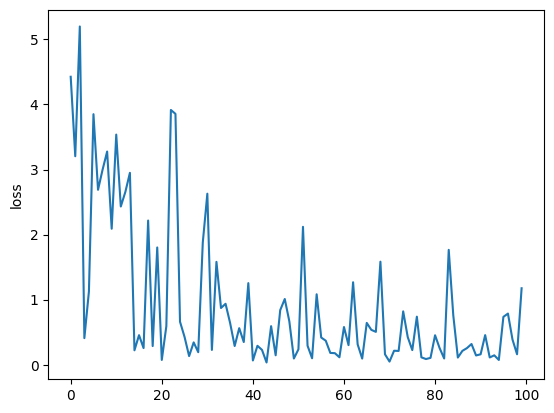

In [82]:
import matplotlib.pyplot as plt

plt.plot(list_o_loss)
plt.ylabel('loss')
plt.show()